# Named Entity Recognition with Bi-Directional LSTMs

This notebook uses pre-tagged data to train a model to predict entities within text.

**Data:**
The data used to train the models is the annotated GMB corpus dataset found on Kaggle, through the following link: https://www.kaggle.com/shoumikgoswami/annotated-gmb-corpus/data
The dataset is a table with a row per word along with its POS and tag and the sentence number that it belongs to.

In [1]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load and explore the data

The sentence of the data will first be transformed into a list of tuples containing the word, POS and tag. Tokens per sentence will then be visualised using a histogram.

In [2]:
data = pd.read_csv("entity-annotated-corpus/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

In [3]:
print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("Dataset sample:")

# Show the first 10 rows
data.head(10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-org', 'B-tim', 'I-nat', 'O', 'I-tim', 'B-eve', 'B-geo', 'B-nat', 'B-gpe', 'I-gpe', 'B-per', 'B-art', 'I-art', 'I-eve', 'I-per', 'B-org', 'I-geo']
Number of Labels:  17
Dataset sample:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


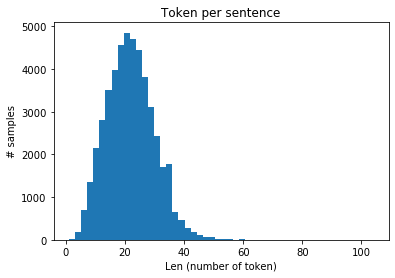

In [4]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()

# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [5]:
print ('Maximum sequence length:', max([len(s) for s in sentences]))

Maximum sequence length: 104


In [6]:
maxlen = 140
word_embedding_size = 300

## Data preprocessing

This step will involve:
+ word2idx dictionary to convert each word to a corresponding integer ID and the tag2idx to do the same for the labels 
+ in order to feed the text into the models, all texts should be the same length. The sequence.pad_sequences() method and maxlen variable; all texts longer than maxlen are truncated and shorter texts are padded to get them to the same length.

In [7]:
#create word list of all words in corpus
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [8]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [9]:
#Vocabulary Key:word -> Value:token_index
word2idx = {w: i for i, w in enumerate(words)}

#Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

#Vocabulary Key:Label/Tag -> Value:tag_index
tag2idx = {t: i for i, t in enumerate(tags)}

#Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

In [10]:
from keras.preprocessing.sequence import pad_sequences
#Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
#Padding each sentence to have the same length
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

In [11]:
#Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
#Padding each sentence to have the same length
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])

from keras.utils import to_categorical
#One-Hot encode
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [12]:
#create test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Bidirectional LSTM Models

Evaluating these models, F1 score will be used primarily. Accuracy is not the best metric as O tag will likely have the highest frequency, and so if a model were to predict all tags as being O it could still obtain a high accuracy rate, where in fact the O tag is the one of least importance - it is the other tags that we are interested in.

### Single Bidirectional Layer

In [13]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(maxlen,))
lstm_model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
lstm_model = Dropout(0.1)(lstm_model)
lstm_model = Bidirectional(LSTM(units=word_embedding_size, return_sequences=True, recurrent_dropout=0.1))(lstm_model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(lstm_model)  #softmax output layer

lstm_model = Model(input, out)

In [14]:
lstm_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 300)          10553700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 600)          1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 17)           10217     
Total params: 12,006,317
Trainable params: 12,006,317
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import ModelCheckpoint

#Saving the best model only
filepath="ner-lstm-model-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [16]:
history = lstm_model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Train on 30693 samples, validate on 7674 samples
Epoch 1/10
30693/30693 [==============================] - 579s 19ms/step - loss: 0.0562 - accuracy: 0.9869 - val_loss: 0.0197 - val_accuracy: 0.9942

Epoch 00001: val_accuracy improved from -inf to 0.99421, saving model to ner-lstm-model-0.994.hdf5
Epoch 2/10
30693/30693 [==============================] - 555s 18ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0174 - val_accuracy: 0.9947

Epoch 00002: val_accuracy improved from 0.99421 to 0.99467, saving model to ner-lstm-model-0.995.hdf5
Epoch 3/10
30693/30693 [==============================] - 549s 18ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.0171 - val_accuracy: 0.9949

Epoch 00003: val_accuracy improved from 0.99467 to 0.99490, saving model to ner-lstm-model-0.995.hdf5
Epoch 4/10
30693/30693 [==============================] - 547s 18ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.0180 - val_accuracy: 0.9948

Epoch 00004: val_accuracy did not improve from 0

In [17]:
#load best model
input = Input(shape=(maxlen,))
lstm_model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
lstm_model = Dropout(0.1)(lstm_model)
lstm_model = Bidirectional(LSTM(units=word_embedding_size, return_sequences=True, recurrent_dropout=0.1))(lstm_model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(lstm_model)  # softmax output layer

lstm_model = Model(input, out)
lstm_model.load_weights('ner-lstm-model-0.995.hdf5')

In [18]:
#function to convert predictios from index to tags
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

test_pred = lstm_model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

9592/9592 [==============================] - 109s 11ms/step


In [20]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 80.9%


In [21]:
from sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

       B-art       0.25      0.01      0.03        73
       B-eve       0.55      0.20      0.29        60
       B-geo       0.84      0.91      0.87      7349
       B-gpe       0.96      0.93      0.95      3165
       B-nat       0.50      0.17      0.26        40
       B-org       0.78      0.71      0.75      4025
       B-per       0.84      0.80      0.82      3396
       B-tim       0.91      0.88      0.90      4140
       I-art       0.00      0.00      0.00        55
       I-eve       0.25      0.28      0.26        43
       I-geo       0.79      0.80      0.80      1505
       I-gpe       1.00      0.51      0.68        37
       I-nat       0.00      0.00      0.00        12
       I-org       0.81      0.75      0.78      3228
       I-per       0.87      0.84      0.85      3468
       I-tim       0.85      0.69      0.76      1316
           O       1.00      1.00      1.00   1310968

    accuracy              

### Adding a CRF Layer

Conditional Random Fields (CRFs) are intended to do task-specific predictions. It is a probabilistic discriminative model. The conditional random field is used for predicting the sequences that use the contextual information to add information that will be used by the model to make correct predictions.

The power of CRF models is particularly useful when the model predicts many variables that are interdependent. NER is a problem of identifying the entities from the text and classifying the entities into a person, location, organisation etc. The main challenge behind the NER problem is that the entities that are too rare to appear in training set due to which the model must identify based only on context. The naive approach to this problem is to classify each word independently. The main problem with this approach is it assumes that named entity labels are independent which is not the case. To tackle this problem CRFs are used where input data is sequence and output is also a sequence and previous context needs to be taken into account when predicting on a data point. For this purpose, a feature function that will have multiple input values is used.

In [22]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(maxlen,))

#Embedding Layer
lstmcrf_model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
lstmcrf_model = Dropout(0.1)(lstmcrf_model)
#BI-LSTM Layer
lstmcrf_model = Bidirectional(LSTM(units=word_embedding_size,return_sequences=True,recurrent_dropout=0.1))(lstmcrf_model)

#TimeDistributed Layer
lstmcrf_model = TimeDistributed(Dense(n_tags, activation="relu"))(lstmcrf_model)  

#CRF Layer
crf = CRF(n_tags)

out = crf(lstmcrf_model)  

#output
lstmcrf_model = Model(input, out)

In [23]:
from keras.callbacks import ModelCheckpoint

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Compile model
lstmcrf_model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
lstmcrf_model.summary()

#Saving the best model only
filepath="ner-lstmcrf-model-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#Fit the best model
history = lstmcrf_model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.1, verbose=1, callbacks=callbacks_list)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 140, 300)          10553700  
_________________________________________________________________
dropout_3 (Dropout)          (None, 140, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140, 600)          1442400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 140, 17)           10217     
_________________________________________________________________
crf_1 (CRF)                  (None, 140, 17)           629       
Total params: 12,006,946
Trainable params: 12,006,946
Non-trainable params: 0
_______________________________________________

In [24]:
#load best weights
input = Input(shape=(maxlen,))

#Embedding Layer
lstmcrf_model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
lstmcrf_model = Dropout(0.1)(lstmcrf_model)
#BI-LSTM Layer
lstmcrf_model = Bidirectional(LSTM(units=word_embedding_size,return_sequences=True,recurrent_dropout=0.1))(lstmcrf_model)

#TimeDistributed Layer
lstmcrf_model = TimeDistributed(Dense(n_tags, activation="relu"))(lstmcrf_model)  

#CRF Layer
crf = CRF(n_tags)

out = crf(lstmcrf_model)  

#output
lstmcrf_model = Model(input, out)

lstmcrf_model.load_weights('ner-lstmcrf-model-0.995.hdf5')

In [25]:
test_pred = lstmcrf_model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

9592/9592 [==============================] - 102s 11ms/step


In [26]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.2%


In [27]:
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        73
       B-eve       1.00      0.22      0.36        60
       B-geo       0.84      0.89      0.87      7349
       B-gpe       0.95      0.93      0.94      3165
       B-nat       0.00      0.00      0.00        40
       B-org       0.77      0.69      0.73      4025
       B-per       0.86      0.79      0.82      3396
       B-tim       0.91      0.87      0.89      4140
       I-art       0.00      0.00      0.00        55
       I-eve       0.00      0.00      0.00        43
       I-geo       0.84      0.76      0.80      1505
       I-gpe       1.00      0.03      0.05        37
       I-nat       0.00      0.00      0.00        12
       I-org       0.76      0.77      0.77      3228
       I-per       0.87      0.84      0.85      3468
       I-tim       0.83      0.69      0.75      1316
           O       1.00      1.00      1.00   1310968

    accuracy              

### Adding an Additional LSTM Layer

In [28]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(maxlen,))

#Embedding Layer
lstmcrf2_model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
lstmcrf2_model = Dropout(0.1)(lstmcrf2_model)
#BI-LSTM Layer
lstmcrf2_model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(lstmcrf2_model)
lstmcrf2_model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(lstmcrf2_model)

# TimeDistributed Layer
lstmcrf2_model = TimeDistributed(Dense(n_tags, activation="relu"))(lstmcrf2_model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(lstmcrf2_model)  

#output
lstmcrf2_model = Model(input, out)

In [30]:
from keras.callbacks import ModelCheckpoint

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Compile model
lstmcrf2_model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
lstmcrf2_model.summary()

#Saving the best model only
filepath="ner-lstmcrf2-model-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#Fit the best model
history = lstmcrf2_model.fit(X_train, np.array(y_train), batch_size=32, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 140, 300)          10553700  
_________________________________________________________________
dropout_5 (Dropout)          (None, 140, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 140, 600)          1442400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 140, 600)          2882400   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 140, 17)           10217     
_________________________________________________________________
crf_3 (CRF)                  (None, 140, 17)           629 

In [31]:
input = Input(shape=(maxlen,))

#Embedding Layer
lstmcrf2_model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
lstmcrf2_model = Dropout(0.1)(lstmcrf2_model)
#BI-LSTM Layer
lstmcrf2_model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(lstmcrf2_model)
lstmcrf2_model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(lstmcrf2_model)

#TimeDistributed Layer
lstmcrf2_model = TimeDistributed(Dense(n_tags, activation="relu"))(lstmcrf2_model)  

#CRF Layer
crf = CRF(n_tags)

out = crf(lstmcrf2_model)  

#output
lstmcrf2_model = Model(input, out)

lstmcrf2_model.load_weights('ner-lstmcrf2-model-0.995.hdf5')

In [32]:
test_pred = lstmcrf2_model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

9592/9592 [==============================] - 210s 22ms/step


In [33]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 83.4%


In [34]:
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        73
       B-eve       0.79      0.25      0.38        60
       B-geo       0.86      0.88      0.87      7349
       B-gpe       0.95      0.94      0.95      3165
       B-nat       1.00      0.03      0.05        40
       B-org       0.76      0.73      0.75      4025
       B-per       0.87      0.80      0.83      3396
       B-tim       0.92      0.87      0.90      4140
       I-art       0.00      0.00      0.00        55
       I-eve       0.40      0.09      0.15        43
       I-geo       0.85      0.75      0.80      1505
       I-gpe       1.00      0.59      0.75        37
       I-nat       0.00      0.00      0.00        12
       I-org       0.78      0.78      0.78      3228
       I-per       0.87      0.85      0.86      3468
       I-tim       0.85      0.71      0.77      1316
           O       1.00      1.00      1.00   1310968

    accuracy              

In [37]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

In [42]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence, y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]], tags[pred])

In [43]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag])) 

tag:I-org
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-tim
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-nat
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:O
	 TN:         0	FP:     38368
	 FN:         0	TP:   2532288
tag:I-tim
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-eve
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-geo
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-nat
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-gpe
	 TN:         0	FP:         0
	 FN:         0	TP:     19184
tag:I-gpe
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-per
	 TN:     19184	FP:         0
	 FN:         0	TP:     38368
tag:B-art
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-art
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-eve
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-per
	 TN:         

## Model Application to Input Text

The model that performed the best will now be applied to our own input text.

In [47]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import re
import string

#Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) #Tokenization
    #Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=140)
    #Evaluation
    p = lstmcrf2_model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    #Visualisation
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

#text to be selected from a BBC news story

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…

In [ ]:
import pickle

#Saving Vocab
with open('models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Additional Potential Modifications for the Model

+ Changing model hyperparameters like the number of epochs, word embedding dimensions, batch size, dropout rate, activations etc.
+ Using a larger dataset. Here there are only 47959 sentences, which are very few to build a good model for entity recognition problem. In particular, a dataset contianing a higher proportion of the tags other than O would be beneficial to improve the model.
+ Using pre-trained word embeddings, such as numberbatch or GloVe.
+ Using character level embedding for LSTM in addition to word level embedding.
+ Fine tuning of the BERT  model.
+ Improve the vocabulary by adding unknown tokens not present in the training set in order to train the model on these tags. 